
# Setup

First, we clone the UniverSeg repo and install necessary dependencies

In [1]:
import os
os.environ['HTTP_PROXY']="http://proxy.l2.med.tohoku.ac.jp:8080"
os.environ['HTTPS_PROXY']="http://proxy.l2.med.tohoku.ac.jp:8080"

In [2]:
!git clone https://github.com/JJGO/UniverSeg
!python -m pip install -q --proxy=http://proxy.l2.med.tohoku.ac.jp:8080 -r ./UniverSeg/requirements.txt

fatal: destination path 'UniverSeg' already exists and is not an empty directory.

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install -q --proxy=http://proxy.l2.med.tohoku.ac.jp:8080 tqdm


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
# !pip list

In [5]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E
import torch
import torch.nn.functional as F

Prepare `universeg`: import, setup GPU, and load model

In [6]:
import sys
sys.path.append('UniverSeg')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

Prepare a quick helpful function for visualizing data for this tutorial

In [7]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

# 表示　とりあえずにbinaryに変換

In [8]:
from collections import defaultdict
import os
import numpy as np

In [9]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    if (y_pred.sum() + y_true.sum()) == 0:
        score = 0
    else: score = score.item()
    return score

In [10]:
# run inference and compute losses for one test image
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

### 関数バージョン

In [13]:
def calculator(organ, image_n):
    file_name = os.listdir(os.path.join("../data4_only_labeltrue/", organ, 'imagesTr'))[image_n]
    source_case_images_path = os.path.join("../data4_only_labeltrue/", organ, 'imagesTr', file_name)
    source_case_labels_path = os.path.join("../data4_only_labeltrue/", organ, 'labelsTr', file_name)
    print(source_case_images_path)

    images = torch.load(source_case_images_path).to('cuda:0')
    images = (images - images.min()) / (images.max() - images.min())
    labels = torch.load(source_case_labels_path).to('cuda:0')
    labels = (labels > 0).int()
    L = images.size()[0]
    n = 5
    # scores_at_all_m = np.full((L, 1), np.nan).tolist()

    if n % 2 == 0:
        m = int(L/2) - int(n//2)
    elif n % 2 ==1:
        m = int(L/2) - int((n//2) + 1)
    print(m, n, L)
    scores_at_specific_m = np.full(L, np.nan).tolist()
    images_at_specific_m = torch.full((L, images.size()[2], images.size()[3]), float('nan'))
    label_at_specific_m = torch.full((L, images.size()[2], images.size()[3]), float('nan'))
    prediction_at_specific_m = torch.full((L, images.size()[2], images.size()[3]), float('nan'))
    
    if m+n <= L:
        # anterograde ##########################################
        if (m+n) != L:
            support_images = images[m:(m+n), :, :, :].float()
            support_labels = labels[m:(m+n), :, :, :].float()
            results_antero = defaultdict(list)

            for i in range(L-(m+n)):
                # print(m+n+i, L-(m+n))
                image = images[(m+n+i), :, :, :].float()
                label = labels[(m+n+i), :, :, :].float()

                # print(image.size(), label.size(), support_images.size(), support_labels.size())
                
                vals = inference(model, image, label, support_images, support_labels)
                for k, v in vals.items():
                    results_antero[k].append(v)
                # support_images = torch.cat((support_images[1:, :, :, :], vals['Image'].unsqueeze(0)), dim=0)
                # support_labels = torch.cat((support_labels[1:, :, :, :], vals['Prediction'].unsqueeze(0)), dim=0)
                
                images_at_specific_m[(m+n+i), :, :] = vals['Image'].unsqueeze(0)
                label_at_specific_m[(m+n+i), :, :] = label
                prediction_at_specific_m[(m+n+i), :, :] = vals['Prediction'].unsqueeze(0)
                
            scores_antero = results_antero.pop('score')
            scores_at_specific_m[(m+n):] = scores_antero
            # visualize_tensors(results_antero,
            #                   col_names=[f'Dice = {100*s:.1f}' for s in scores_antero],
            #                   title='Test Predictions',
            #                   col_wrap=(L-(m+n)))


        # retrograde ##########################################
        if m != 0:
            support_images = images[m:(m+n), :, :, :].float()
            support_labels = labels[m:(m+n), :, :, :].float()

            results_retro = defaultdict(list)

            for i in range(m):
                # print(m-i-1)
                image = images[(m-i-1), :, :, :].float()
                label = labels[(m-i-1), :, :, :].float()
                vals = inference(model, image, label, support_images, support_labels)
                for k, v in vals.items():
                    results_retro[k].append(v)
                # support_images = torch.cat((vals['Image'].unsqueeze(0), support_images[:(n-1), :, :, :]), dim=0)
                # support_labels = torch.cat((vals['Prediction'].unsqueeze(0), support_labels[:(n-1), :, :, :]), dim=0)
                
                images_at_specific_m[(m-i-1), :, :] = vals['Image'].unsqueeze(0)
                label_at_specific_m[(m-i-1), :, :] = label
                prediction_at_specific_m[(m-i-1), :, :] = vals['Prediction'].unsqueeze(0)

            scores_retro = results_retro.pop('score')
            scores_at_specific_m[0:m] = scores_retro[::-1]

            # visualize_tensors(results_retro,
            #                   col_names=[f'Dice = {100*s:.1f}' for s in scores_retro],
            #                   title='Test Predictions_retro',
            #                   col_wrap= m)
        # scores_at_all_m[m] = scores_at_specific_m
                
            


    # NaNを含むリストをNumpy配列に変換
    data = np.array(scores_at_specific_m)
    
    # # NaN値を補間またはマスク処理（ここではマスクとして扱う）
    # masked_data = np.ma.masked_invalid(data)
    
    # ヒートマップを作成
    plt.figure(figsize=(10, 8))
    cax = plt.plot(data)
    plt.axvspan(m-0.5, m+n-0.5, color='yellow', alpha=0.5)
    plt.title('Score Variation [' + organ + '_n' + str(source_case_images_path[-5:-3]) + ']')
    plt.xlabel('Position x')
    plt.ylabel('Dice')
    
    # プロット表示
    plt.savefig('../results/expe_20240507_cen_baseline/'+ organ + '/n' + str(source_case_images_path[-5:-3]))
    plt.close()

    np.savetxt('../results/expe_20240507_cen_baseline/'+ organ + '/n' + str(source_case_images_path[-5:-3]), data, delimiter=',')
    torch.save(images_at_specific_m, '../results/expe_20240507_cen_baseline/'+ organ + '/n' + str(source_case_images_path[-5:-3]) + '_img.pth')
    torch.save(label_at_specific_m, '../results/expe_20240507_cen_baseline/'+ organ + '/n' + str(source_case_images_path[-5:-3]) + '_label.pth')
    torch.save(prediction_at_specific_m, '../results/expe_20240507_cen_baseline/'+ organ + '/n' + str(source_case_images_path[-5:-3]) + '_pred.pth')

In [14]:
for organ in ["Task02_Heart"]:
    for n in range(len(os.listdir(os.path.join("../data4_only_labeltrue/", organ, 'imagesTr')))):
    # for n in range(1):    
        calculator(organ, n)

../data4_only_labeltrue/Task02_Heart/imagesTr/la_007.pt
35 5 76
../data4_only_labeltrue/Task02_Heart/imagesTr/la_019.pt
34 5 74
../data4_only_labeltrue/Task02_Heart/imagesTr/la_023.pt
24 5 54
../data4_only_labeltrue/Task02_Heart/imagesTr/la_005.pt
34 5 74
../data4_only_labeltrue/Task02_Heart/imagesTr/la_009.pt
36 5 79
../data4_only_labeltrue/Task02_Heart/imagesTr/la_017.pt
29 5 64
../data4_only_labeltrue/Task02_Heart/imagesTr/la_021.pt
32 5 71
../data4_only_labeltrue/Task02_Heart/imagesTr/la_029.pt
27 5 60
../data4_only_labeltrue/Task02_Heart/imagesTr/la_003.pt
30 5 66
../data4_only_labeltrue/Task02_Heart/imagesTr/la_011.pt
31 5 68
../data4_only_labeltrue/Task02_Heart/imagesTr/la_030.pt
31 5 69
../data4_only_labeltrue/Task02_Heart/imagesTr/la_022.pt
26 5 58
../data4_only_labeltrue/Task02_Heart/imagesTr/la_014.pt
30 5 66
../data4_only_labeltrue/Task02_Heart/imagesTr/la_018.pt
31 5 68
../data4_only_labeltrue/Task02_Heart/imagesTr/la_020.pt
32 5 70
../data4_only_labeltrue/Task02_Heart/ima

In [48]:
for organ in ["Task04_Hippocampus"]:
    for n in range(len(os.listdir(os.path.join("../data4_only_labeltrue/", organ, 'imagesTr')))):
        calculator(organ, n)

../data4_only_labeltrue/Task04_Hippocampus/imagesTr/hippocampus_367.pt
11 5 28


RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 8 but got size 9 for tensor number 1 in the list.

In [15]:
for organ in ["Task05_Prostate"]:
    for n in range(len(os.listdir(os.path.join("../data4_only_labeltrue/", organ, 'imagesTr')))):
        calculator(organ, n)

../data4_only_labeltrue/Task05_Prostate/imagesTr/prostate_16.pt
7 5 20
../data4_only_labeltrue/Task05_Prostate/imagesTr/prostate_04.pt
4 5 14
../data4_only_labeltrue/Task05_Prostate/imagesTr/prostate_32.pt
2 5 11
../data4_only_labeltrue/Task05_Prostate/imagesTr/prostate_20.pt
5 5 17
../data4_only_labeltrue/Task05_Prostate/imagesTr/prostate_43.pt
3 5 13
../data4_only_labeltrue/Task05_Prostate/imagesTr/prostate_18.pt
5 5 17
../data4_only_labeltrue/Task05_Prostate/imagesTr/prostate_06.pt
5 5 17
../data4_only_labeltrue/Task05_Prostate/imagesTr/prostate_14.pt
4 5 14
../data4_only_labeltrue/Task05_Prostate/imagesTr/prostate_41.pt
5 5 16
../data4_only_labeltrue/Task05_Prostate/imagesTr/prostate_34.pt
3 5 13
../data4_only_labeltrue/Task05_Prostate/imagesTr/prostate_38.pt
7 5 20
../data4_only_labeltrue/Task05_Prostate/imagesTr/prostate_10.pt
2 5 11
../data4_only_labeltrue/Task05_Prostate/imagesTr/prostate_02.pt
6 5 18
../data4_only_labeltrue/Task05_Prostate/imagesTr/prostate_24.pt
6 5 18
../dat

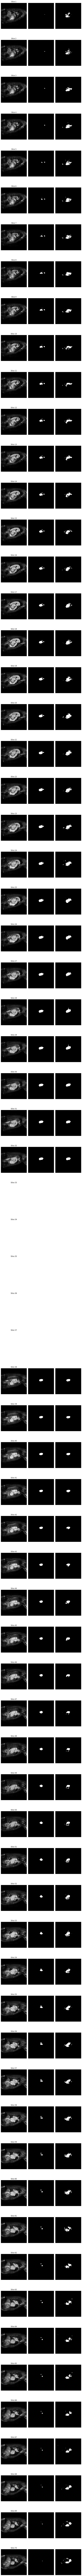

In [16]:
import torch
import matplotlib.pyplot as plt

# データの読み込み（PyTorchのテンソルとして）
images = torch.load('../results/expe_20240507_cen_baseline/Task02_Heart/n04_img.pth')  # 形状は (M, H, W)
labels = torch.load('../results/expe_20240507_cen_baseline/Task02_Heart/n04_label.pth')  # 形状は (M, H, W)
preds = torch.load('../results/expe_20240507_cen_baseline/Task02_Heart/n04_pred.pth')    # 形状は (M, H, W)

# テンソルをnumpy配列に変換
images_np = images.numpy()
labels_np = labels.numpy()
preds_np = preds.numpy()

# スライスの数
M = images.shape[0]

# サブプロットの作成
fig, axs = plt.subplots(M , 3, figsize=(9, 4*M))

for i in range(M):
    # 各スライスを描画
    axs[i, 0].imshow(images_np[i], cmap='gray')
    axs[i, 0].axis('off')  # 軸の非表示
    axs[i, 0].set_title(f'Slice {i+1}')

    axs[i, 1].imshow(labels_np[i], cmap='gray')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(preds_np[i], cmap='gray')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()